If running on google colab, uncomment this cell to install thoi

In [ ]:
#!pip install thoi

In [1]:
import scipy.io
import torch
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy, simulated_annealing_multi_order
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import time
import os
import sys
import zipfile
import urllib.request
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

We use freely available data from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10572216.svg)](https://zenodo.org/records/10572216)



In [ ]:
# --- Detect environment ---
if "google.colab" in sys.modules:
    base_path = "/content/cmha_data"
else:
    base_path = os.path.join(os.getcwd(), "cmha_data")

os.makedirs(base_path, exist_ok=True)

url = "https://zenodo.org/records/10572216/files/cmha-1.0.0.zip?download=1"
zip_path = os.path.join(base_path, "cmha-1.0.0.zip")
expected_folder = os.path.join(base_path, "cmha-1.0.0")

# --- Check if already extracted ---
if os.path.exists(expected_folder):
    print(f"Dataset already extracted at: {expected_folder}")
else:
    # --- Download if missing ---
    if not os.path.exists(zip_path):
        print(f"Downloading dataset from Zenodo to {zip_path}...")
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete.")
    else:
        print("Zip file already exists, skipping download.")

    # --- Extract ---
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(base_path)
    print("\nData extracted at:", base_path)

In [3]:
# Load record information
record_metadata = pd.read_csv(f"{base_path}/cmha-1.0.0/data/participants.tsv",delimiter='\t')
# Load fMRI records
data_CoCoMAC = np.load(f"{base_path}/cmha-1.0.0/data/CoCoMac/timeseries.npy")

print("Subjects were recorded under 6 states",record_metadata['cond'].unique())
record_metadata.head(5)
print("\n")
print(f"Data shape {data_CoCoMAC.shape} indicates that there are 156 records from 82 brain regions with 500 samples each")

Subjects were recorded under 6 states ['awake' 'ketamine' 'moderate-propofol' 'deep-propofol'
 'moderate-sevoflurane' 'deep-sevoflurane']


Data shape (156, 500, 82) indicates that there are 156 records from 82 brain regions with 500 samples each


We can store all the information in a dictionary for ease of access

In [5]:
all_states = {}

for state_name in record_metadata['cond'].unique():
    all_states[state_name] = {}
    state_df = record_metadata.query("cond==@state_name")
    sub_idx = 1
    for idx, row in state_df.iterrows():
        all_states[row.cond][sub_idx] = data_CoCoMAC[idx]
        sub_idx+=1

### Example usage cells for THOI

 - THOI expects input of shape (n_records, n_samples, n_channels)

 - n_records can be 1

* `nplets_measures(X, nplet_list=None, **kwargs)` — computes *O-information* (or higher-order interaction measures) for specified subsets (n-plets) of variables (brain regions).

  * `X`: a 2D or 3D array `shape = (n_samples, n_variables)` or `(n_records, n_samples, n_variables)`.
  * `nplet_list`: a list of lists, each inner list is a set of variable indices e.g. `[[0,1,2], [2,5,7,8]]`.
  * If you omit `nplet_list`, it defaults to computing for *all possible combinations* up to the order of the records (all available variables).
  
* `multi_order_measures(X, **kwargs)` — computes **all** orders of interaction measures across combinations (e.g. pairwise, triplets, etc.).
  * Use with caution, because combinatorial explosion can make this very heavy for many variables.

* `greedy(X, order, k, repeat=…)` — a heuristic to search for the *best* subsets (nplets) of a given order (size) that maximize some measure.

  * `order`: the size of nplets (e.g. 3 for triplets).
  * `k`: number of top subsets to return.
  * `repeat`: how many independent runs / restarts.
* `simulated_annealing(X, order, repeat=…, init=None)` — alternative heuristic search to find high-scoring subsets.

  * Optionally you can supply `init` (initial solutions) or let it pick random ones.

---

### 🧪 Toy examples of computing measures


In [6]:
# We take a single record from the awake state
X = all_states['awake'][1]

In [7]:
# Example 1: compute O-information and related measures for a small set of triplets

triplet_indices = [[0, 1, 2], [0, 3, 5], [10, 20, 30]]
measures_triplets = nplets_measures(X, triplet_indices)
# measures_triplets is a torch tensor with results for each triplet (3 rows and 4 columns, one column per measure)

measures_triplets = measures_triplets.squeeze(1).cpu().numpy()  # shape now (3, 4)
measures_triplets = pd.DataFrame(measures_triplets, columns=["TC", "DTC", "O", "S"])
print("Triplet measures:\n", measures_triplets)

Triplet measures:
          TC       DTC         O         S
0  0.311276  0.353818 -0.042542  0.665094
1  0.649606  0.647871  0.001735  1.297477
2  0.585338  0.775441 -0.190103  1.360779


### Heuristic search for "optimal" subsets

Both `greedy()` and `simulated_annealing()` are optimization algorithms used to search for n-plets (groups of variables, e.g. brain regions) that maximize or minimize information-theoretic quantities such as O-information, Total Correlation, or Dual Total Correlation.

This part requires more computational power, so gpu usage is recommended (device='cuda')

In [ ]:
# We take a single record from the deep-propofol state
X = all_states['deep-propofol'][1]

# --- Greedy search example ---
best_triplets, best_scores = greedy(
    X,
    order=3,           # look for triplets
    repeat=10,         # 10 independent random restarts
    batch_size=128,    # evaluate 128 candidate triplets at once
    metric = 'o',      # select O-information as the measure to optimize
    largest=False,     # minimize measure
    device=device,     # use GPU if available (device = 'cuda' or 'cpu')
)

# best_triplets has shape (10, 3): 10 independent runs over triplets (3 regions)
# best_scores has shape (10, 1): one score for each of the runs (O-Information)
# We take the best scoring nplet (notice that we take argmin because we are minimizing O-Information):

best_idx = best_scores.argmin()

triplet = best_triplets[best_idx].tolist() # tensor to list so we can show it
score = best_scores[best_idx].item() # tensor to numpy so we can show it

print("Best triplet found by greedy search (minimizes O-Information):")
print(f"{triplet} → O-info = {score:.4f}")





Best triplet found by greedy search (minimizes O-Information):
[73, 74, 76] → O-info = -0.4249


In [61]:
# --- Simulated Annealing example ---
best_quartets, best_scores = simulated_annealing(
    X,
    order=4,               # quartets of brain regions
    repeat=5,              # 5 independent runs
    max_iterations=500,    # up to 500 annealing steps per run
    batch_size=64,         # evaluate 64 candidates in parallel
    metric = 'dtc',        # select Dual Total Correlation as the measure to optimize
    largest=True,          # maximize measure
    early_stop=200,        # stop if no improvement after 200 steps
    device=device,         # use GPU if available (device = 'cuda' or 'cpu')
)

# best_quartets has shape (5, 4): 5 independent runs over quartets (4 regions)
# best_scores has shape (5, 1): one score for each of the runs (DTC)
# We take the best scoring nplet (notice that now we take argmax because we are maximizing DTC):

best_idx = best_scores.argmax()

quartet = best_quartets[best_idx].tolist() # tensor to list so we can show it
score = best_scores[best_idx].item() # tensor to numpy so we can show it

print("Best quartet found by greedy search (maximizes DTC):")
print(f"{quartet} → DTC = {score:.4f}")

mean(dtc) = 1.2930670542576614 - ES: 199:  93%|█████████▎| 466/500 [00:03<00:00, 121.03it/s]2025-10-17 12:37:03,749 - INFO - Early stop reached
                                                                                            

Best quartet found by greedy search (maximizes DTC):
[38, 55, 77, 14] → DTC = 1.3562


### We can maximize measures accross many records:

In [43]:
X = np.stack([all_states['awake'][k] for k in all_states['awake'].keys()], axis=0) # take all awake records

Special precautions: increasing repeat, order or batch size --> higher GPU memory usage

In [51]:
# --- Simulated Annealing example ---
best_quartets, best_scores = simulated_annealing(
    X,
    order=4,               # quartets of brain regions
    repeat=100,            # 100 independent runs
    max_iterations=1000,    # up to 500 annealing steps per run
    batch_size=1000000,    # evaluate 100000 candidates in parallel
    metric = 'dtc',        # select Dual Total Correlation as the measure to optimize
    largest=True,          # maximize measure
    early_stop=500,        # stop if no improvement after 200 steps
    device=device,         # use GPU if available (device = 'cuda' or 'cpu')
)

# best_quartets has shape (5, 4): 5 independent runs over quartets (4 regions)
# best_scores has shape (5, 1): one score for each of the runs (DTC)
# We take the best scoring nplet (notice that now we take argmax because we are maximizing DTC):

best_idx = best_scores.argmax()

quartet = best_quartets[best_idx].tolist() # tensor to list so we can show it
score = best_scores[best_idx].item() # tensor to numpy so we can show it

print("Best quartet found by Simulated Annealing search (maximizes DTC):")
print(f"{quartet} → mean DTC = {score:.4f}")

Best quartet found by Simulated Annealing search (maximizes DTC):
[80, 55, 14, 39] → mean DTC = 2.1223


### We can then evaluate this optimal nplet on the subjects:

In [54]:
measure_results = []
for state_name, state_dict in all_states.items():
    for record_id, record_data in state_dict.items():
        TC, DTC, O, S = nplets_measures(record_data, [[80, 55, 14, 39]])[0,0]
        measure_results.append({
            "state": state_name,
            "record_id": record_id,
            "TC":TC.item(), #convert from tensor
            "DTC":DTC.item(), #convert from tensor
            "O":O.item(), #convert from tensor
            "S":S.item(), #convert from tensor

        })
measures_df = pd.DataFrame(measure_results)

measures_df.head()

,state,record_id,TC,DTC,O,S
0,awake,1,3.884544,3.130921,0.753623,7.015465
1,awake,2,3.756748,3.342739,0.414009,7.099487
2,awake,3,2.432826,2.527864,-0.095039,4.960690
3,awake,4,2.636176,2.615456,0.020720,5.251632
4,awake,5,1.746118,1.759012,-0.012895,3.505130


#### Let's visualize the results

Text(0.5, 0, '')

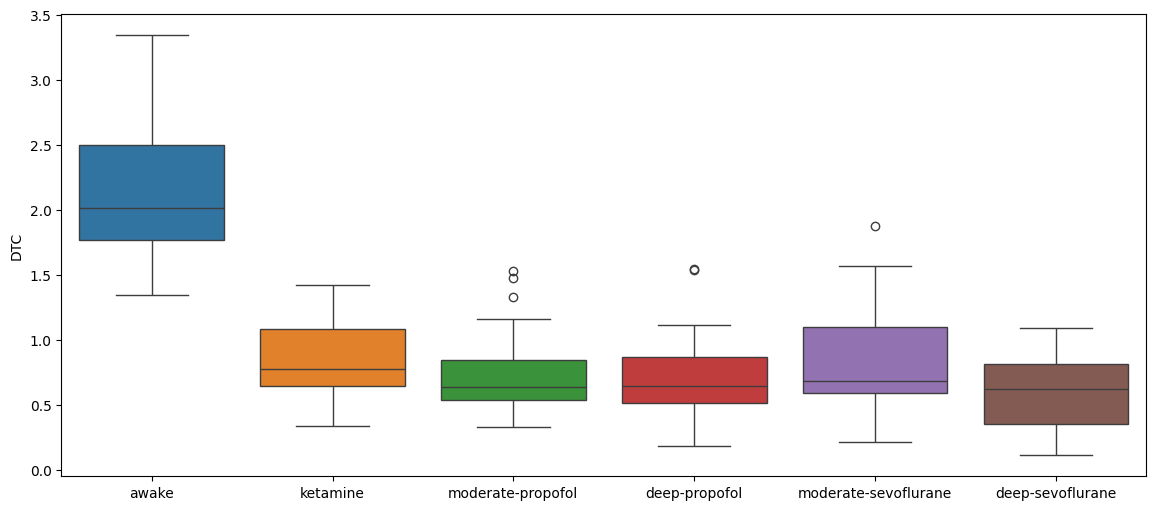

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(measures_df,x='state',hue='state',y='DTC')
plt.xlabel('')

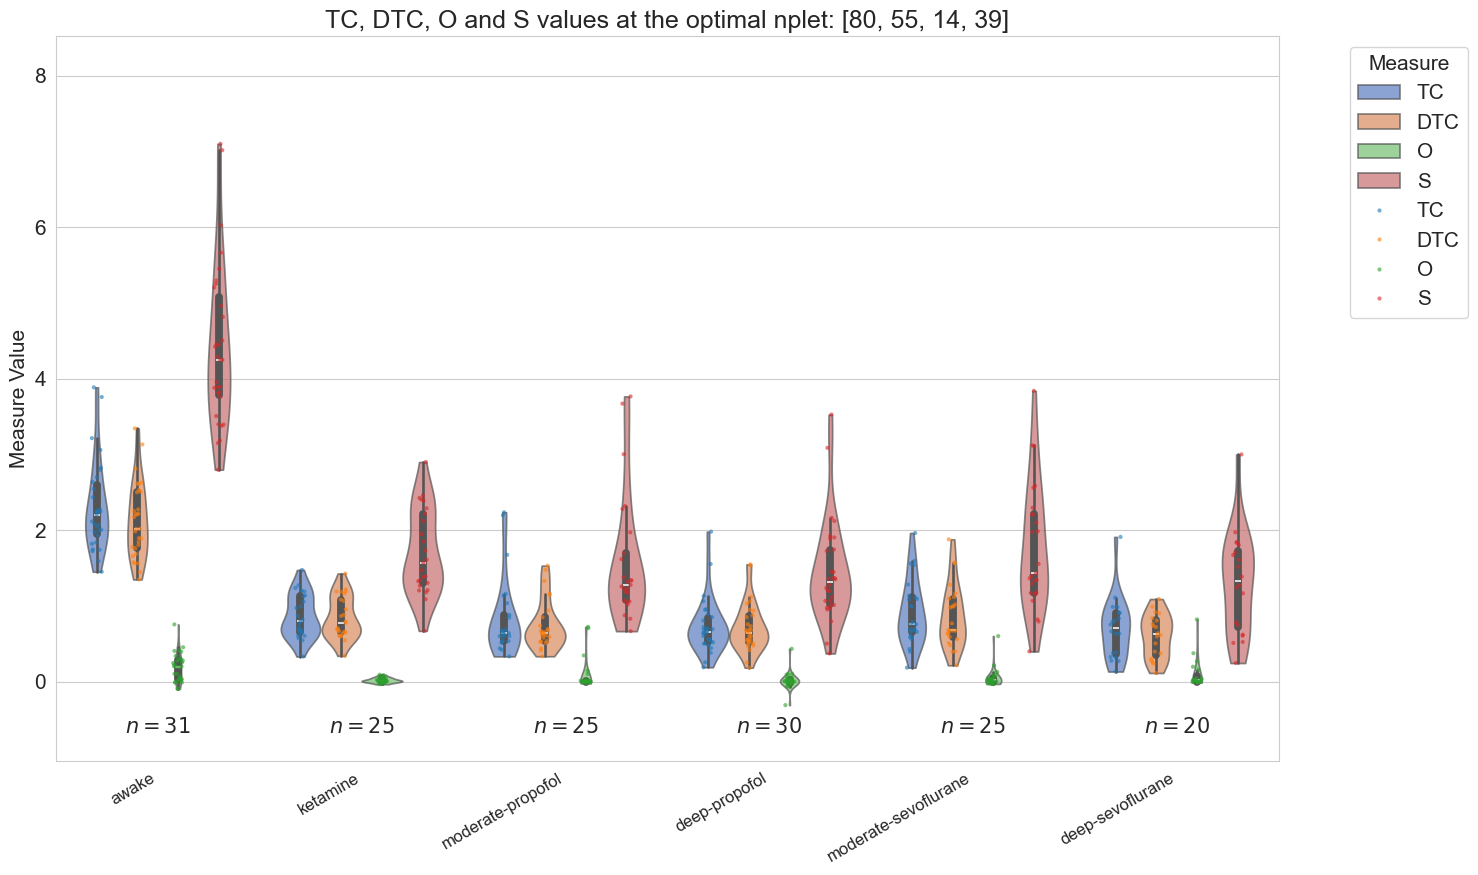

In [60]:
plt.rcParams.update({"font.size": 15})

# Melt DataFrame for plotting
df_melted = measures_df.melt(
    id_vars=["state", "record_id"], var_name="Measure", value_name="Value"
)

custom_order = ['awake', 'ketamine', 'moderate-propofol', 'deep-propofol', 'moderate-sevoflurane', 'deep-sevoflurane']
# Initialize plot
plt.figure(figsize=(15, 9))
sns.set_style("whitegrid")

# Create violin + boxplot with individual markers
ax = sns.violinplot(
    data=df_melted,
    x="state",
    y="Value",
    hue="Measure",
    inner="box",
    palette="muted",
    dodge=True,
    alpha=0.7,
    cut=0,
    order=custom_order,
)

# # Overlay individual subject markers
strip = sns.stripplot(
    data=df_melted,
    x="state",
    y="Value",
    hue="Measure",
    dodge=True,
    jitter=True,
    alpha=0.6,
    size=3,
    order=custom_order,
)

# Annotate number of samples on top of each violin
y_max = df_melted["Value"].max()  # Adjust spacing for bars
y_min = df_melted["Value"].min()  # Adjust spacing for bars
bar_height = (y_max - y_min) * 0.1  # Vertical space between bars
# Annotate sample sizes
for i, state in enumerate(custom_order):
    n_samples = len(measures_df[measures_df["state"] == state])
    plt.text(
        i,
        y_min - bar_height * 0.5,
        rf"$n={n_samples}$",
        ha="center",
        fontweight="bold",
    )

# Beautify plot
plt.title(f"TC, DTC, O and S values at the optimal nplet: {quartet}")
# plt.xlabel("State")
plt.xlabel("")
plt.ylabel("Measure Value")
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.ylim(y_min - bar_height, y_max * 1.2)
plt.legend(title="Measure", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Simmulated annealing can be used over custom functions through *simulated_annealing(metric=custom_fc)*. Check `simulated_annealing_awake_vs_rest.ipynb` for an example